# Setup

In [1]:
!pip install pytorch-lightning lightning-bolts --quiet

     |████████████████████████████████| 916 kB 7.5 MB/s 
     |████████████████████████████████| 253 kB 69.4 MB/s 
     |████████████████████████████████| 636 kB 56.1 MB/s 
     |████████████████████████████████| 118 kB 54.1 MB/s 
     |████████████████████████████████| 272 kB 74.7 MB/s 
     |████████████████████████████████| 829 kB 43.2 MB/s 
     |████████████████████████████████| 1.3 MB 52.2 MB/s 
     |████████████████████████████████| 142 kB 69.8 MB/s 
     |████████████████████████████████| 294 kB 69.8 MB/s 


In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import resnet18, resnet50

import pytorch_lightning as pl
from pl_bolts.models.autoencoders import AE, VAE
from pl_bolts.models.self_supervised import SimCLR
from pl_bolts.datamodules.cifar10_datamodule import CIFAR10
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization

from sklearn.metrics.pairwise import cosine_distances
from scipy.stats import spearmanr

matplotlib.style.use('fivethirtyeight')
np.set_printoptions(threshold=np.inf)

In [3]:
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

with np.load(fname) as dobj:
    dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

stim = dat['stimuli']
stim_test = dat['stimuli_test']
fmri_responses = dat['responses']
fmri_responses_test = dat['responses_test']
roi = dat['roi']
roi_names = dat['roi_names']
roi_map = {name: idx for idx, name in enumerate(dat['roi_names'])}
del roi_map['Other']

# Network Initializations

We use two networks for our comparisons:
- Task Optimized: A ResNet-18 based pretrained classifier 
- Task Agnostic: A ResNet-18 based pretrained autoencoder

*TODO: Add self-supervised learning models?*

In [4]:
ae = VAE(input_height=32).from_pretrained('cifar10-resnet18')
ae = ae.cuda()

Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/vae/vae-cifar10/checkpoints/epoch%3D89.ckpt" to /root/.cache/torch/hub/checkpoints/epoch%3D89.ckpt


  0%|          | 0.00/230M [00:00<?, ?B/s]

In [5]:
classifier = resnet18(pretrained=True)
classifier = classifier.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [6]:
# Hooks to get feature-activations at different layers for the autoencoder
activations = {}
def get_activation_vae(name):
  def hook(model, input, output):
    activations[name] = output.detach()
  return hook
# ae.encoder.maxpool.register_forward_hook(get_activation('layer0'))
ae.encoder.layer1[0].register_forward_hook(get_activation_vae('layer1_0'))
ae.encoder.layer1.register_forward_hook(get_activation_vae('layer1'))
ae.encoder.layer2[0].register_forward_hook(get_activation_vae('layer2_0'))
ae.encoder.layer2.register_forward_hook(get_activation_vae('layer2'))
ae.encoder.layer3[0].register_forward_hook(get_activation_vae('layer3_0'))
ae.encoder.layer3.register_forward_hook(get_activation_vae('layer3'))
ae.encoder.layer4[0].register_forward_hook(get_activation_vae('layer4_0'))
ae.encoder.layer4.register_forward_hook(get_activation_vae('layer4'))

In [7]:
# Hooks to get feature-activations at different layers for the classifer
activations_classifier = {}
def get_activation_classifier(name):
  def hook(model, input, output):
    activations_classifier[name] = output.detach()
  return hook

# classifier.maxpool.register_forward_hook(get_activation('layer0'))
classifier.layer1.register_forward_hook(get_activation_classifier('layer1'))
classifier.layer1[0].register_forward_hook(get_activation_classifier('layer1_0'))
classifier.layer2[0].register_forward_hook(get_activation_classifier('layer2_0'))
classifier.layer2.register_forward_hook(get_activation_classifier('layer2'))
classifier.layer3[0].register_forward_hook(get_activation_classifier('layer3_0'))
classifier.layer3.register_forward_hook(get_activation_classifier('layer3'))
classifier.layer4[0].register_forward_hook(get_activation_classifier('layer4_0'))
classifier.layer4.register_forward_hook(get_activation_classifier('layer4'))

In [8]:
def make_input_multichannel(input, output_dim=32):
  """Pipeline to make input images multichannel by copying same."""
  input = torch.tensor(input)
  input = torch.stack((input,)*3, axis=-1)
  input = input.permute((0, 3, 1, 2))
  input = nn.functional.interpolate(input, size=output_dim)
  input = cifar10_normalization()(input)

  return input

In [9]:
# Forward-pass through the networks to get layer activations
input_tensor = make_input_multichannel(stim, 32).cuda()
_ = classifier(input_tensor)
_ = ae.encoder(input_tensor)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# Representation Similiarity Analysis

To compare representational-similiarity between a brain region and a network layer, we use the following approach:
- Compute a pairwise dissimilarity matrix A based on the fMRI voxel responses for images.
- Compute a pairwise dissimilarity matrix B based on the layer-activations for the images
- Compute the Spearman rank correlation between A and B: this is a quantitative measure of the similarity of image representations between the brain region and the network layer.

A similar procedure can be followed to compute the representational-similiarity between corresponding layers of two networks.

In [10]:
def compute_similarity(region, layer):
  """ Compute RS between a brain region and a network layer """
  layer = layer.cpu().numpy().reshape([layer.shape[0], -1])
  dm_layer = cosine_distances(layer)
  dm_region = cosine_distances(region)
  s = spearmanr(dm_layer.flatten(), dm_region.flatten())
  # print(s.pvalue)
  return s.correlation

## Similiarity between brain regions and network layers for the AE

In [11]:
fmri_v1 = fmri_responses[:, roi == roi_map['V1']]
fmri_latocc = fmri_responses[:, roi == roi_map['LatOcc']]

sim_v1_vae = [compute_similarity(fmri_v1, activations[key])
          for key in activations.keys()]
sim_latocc_vae = [compute_similarity(fmri_latocc, activations[key])
              for key in activations.keys()]

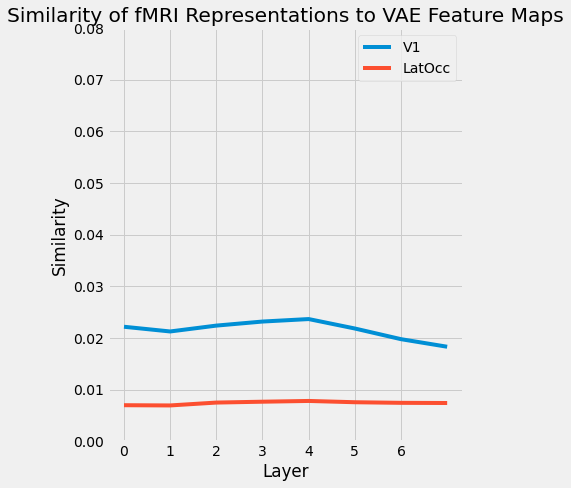

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(sim_v1_vae, label='V1')
ax.plot(sim_latocc_vae, label='LatOcc')
ax.set(title='Similarity of fMRI Representations to VAE Feature Maps',
       xlabel='Layer', ylabel='Similarity', xticks=range(0, 7), ylim=(0, 0.08))
      #  xticks=[0, 1, 2, 3,], xticklabels=['A', 'B', 'C', 'D'])
ax.legend()
plt.tight_layout()
plt.show()

## Similar Images according to a VAE

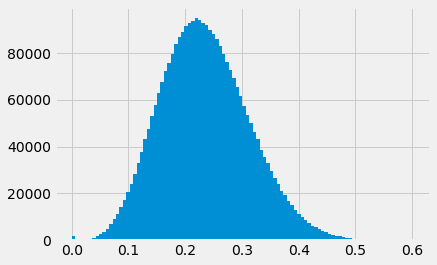

In [13]:
vae_layer4 = activations['layer4'].cpu().numpy()
vae_layer4 = vae_layer4.reshape([vae_layer4.shape[0], -1])
vae_layer4_dm = cosine_distances(vae_layer4)
plt.hist(vae_layer4_dm.flatten(), bins=100)
plt.show()

In [14]:
print(np.argwhere(vae_layer4_dm < 0.1))

[[   0    0]
 [   0   35]
 [   0  476]
 [   0  705]
 [   0  721]
 [   0 1512]
 [   0 1692]
 [   1    1]
 [   1   57]
 [   1   64]
 [   1   71]
 [   1   84]
 [   1   93]
 [   1  105]
 [   1  124]
 [   1  147]
 [   1  191]
 [   1  202]
 [   1  203]
 [   1  208]
 [   1  245]
 [   1  275]
 [   1  311]
 [   1  323]
 [   1  328]
 [   1  333]
 [   1  335]
 [   1  348]
 [   1  385]
 [   1  392]
 [   1  401]
 [   1  414]
 [   1  417]
 [   1  435]
 [   1  440]
 [   1  483]
 [   1  496]
 [   1  502]
 [   1  503]
 [   1  527]
 [   1  556]
 [   1  586]
 [   1  627]
 [   1  663]
 [   1  679]
 [   1  681]
 [   1  703]
 [   1  768]
 [   1  826]
 [   1  834]
 [   1  839]
 [   1  841]
 [   1  851]
 [   1  936]
 [   1  988]
 [   1 1008]
 [   1 1030]
 [   1 1093]
 [   1 1097]
 [   1 1154]
 [   1 1181]
 [   1 1198]
 [   1 1207]
 [   1 1209]
 [   1 1212]
 [   1 1274]
 [   1 1290]
 [   1 1310]
 [   1 1315]
 [   1 1377]
 [   1 1379]
 [   1 1458]
 [   1 1468]
 [   1 1478]
 [   1 1497]
 [   1 1536]
 [   1 1554]

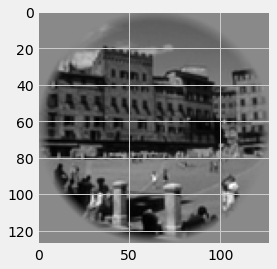

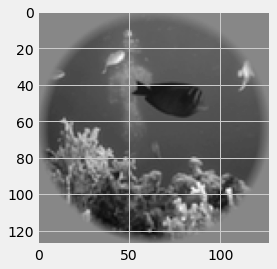

In [15]:
plt.imshow(stim[1748, :, :], cmap='gray')
plt.show()
plt.imshow(stim[1745, :, :], cmap='gray')
plt.show()

## Similiarity between brain regions and network layers for the classifier

In [16]:
fmri_v1 = fmri_responses[:, roi == roi_map['V1']]
fmri_latocc = fmri_responses[:, roi == roi_map['LatOcc']]

sim_v1_classifier = [compute_similarity(fmri_v1, activations_classifier[key])
          for key in activations_classifier.keys()]
sim_latocc_classifier = [compute_similarity(fmri_latocc, activations_classifier[key])
              for key in activations_classifier.keys()]

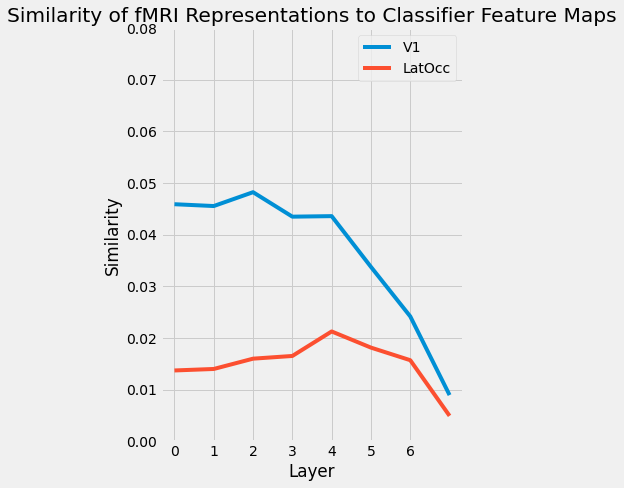

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(sim_v1_classifier, label='V1')
ax.plot(sim_latocc_classifier, label='LatOcc')
ax.set(title='Similarity of fMRI Representations to Classifier Feature Maps',
       xlabel='Layer', ylabel='Similarity', xticks=range(0, 7), ylim=(0, 0.08))
      #  xticks=[0, 1, 2, 3,], xticklabels=['A', 'B', 'C', 'D'])
ax.legend()
plt.tight_layout()
plt.show()

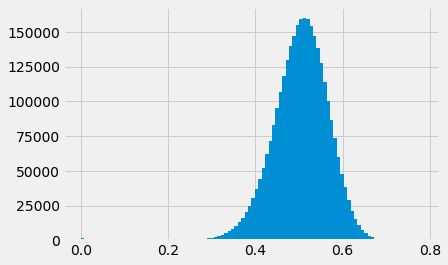

In [18]:
classifier_layer4 = activations_classifier['layer2'].cpu().numpy()
classifier_layer4 = classifier_layer4.reshape([classifier_layer4.shape[0], -1])
classifier_layer4_dm = cosine_distances(classifier_layer4)
plt.hist(classifier_layer4_dm.flatten(), bins=100)
plt.show()

In [19]:
print(np.argwhere(classifier_layer4_dm + np.eye(classifier_layer4_dm.shape[0]) < 0.15))

[[  30 1309]
 [  99 1694]
 [ 105  663]
 [ 144 1637]
 [ 170 1159]
 [ 202 1562]
 [ 465 1626]
 [ 593 1562]
 [ 663  105]
 [1047 1333]
 [1159  170]
 [1309   30]
 [1333 1047]
 [1562  202]
 [1562  593]
 [1626  465]
 [1637  144]
 [1694   99]]


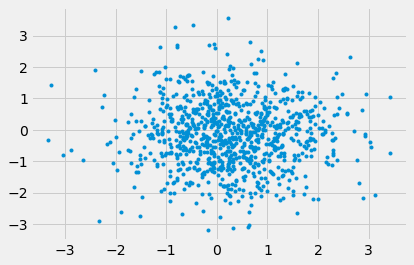

In [20]:
plt.plot(fmri_responses[105, roi == roi_map['LatOcc']], fmri_responses[663, roi == roi_map['LatOcc']], '.')
plt.show()

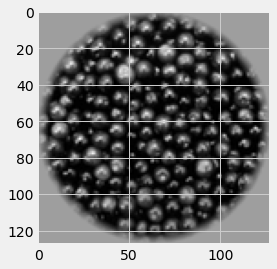

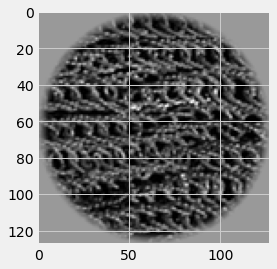

In [21]:
plt.imshow(stim[105, :, :], cmap='gray')
plt.show()
plt.imshow(stim[663, :, :], cmap='gray')
plt.show()

# Similiarity between autoencoder representations and classifier representations

In [22]:
def compute_layer_similarity(layer):
  """ Compute RS between a brain region and a network layer """
  classifier_layer = activations_classifier[layer].cpu().numpy()
  classifier_layer = classifier_layer.reshape([classifier_layer.shape[0], -1])
  # print(classifier_layer.shape)
  encoder_layer = activations[layer].cpu().numpy()
  encoder_layer = encoder_layer.reshape([encoder_layer.shape[0], -1])
  # print(encoder_layer.shape)
  dm_classifier = cosine_distances(classifier_layer)
  dm_encoder = cosine_distances(encoder_layer)
  s = spearmanr(dm_classifier.flatten(), dm_encoder.flatten())
  # print(s.pvalue)
  return s.correlation

In [23]:
#print(compute_layer_similarity('layer0'))
print(compute_layer_similarity('layer1'))
print(compute_layer_similarity('layer2'))
print(compute_layer_similarity('layer3'))
print(compute_layer_similarity('layer4'))

0.6315049284423251
0.5165459475753664
0.31689708543517975
0.05178835777035113


# Comparison with self-supervised learning methods

In [24]:
del classifier, ae

In [25]:
weight_path = 'https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt'
simclr = SimCLR.load_from_checkpoint(weight_path, strict=False)
classifier_50 = resnet50(pretrained=True)

Downloading: "https://pl-bolts-weights.s3.us-east-2.amazonaws.com/simclr/bolts_simclr_imagenet/simclr_imagenet.ckpt" to /root/.cache/torch/hub/checkpoints/simclr_imagenet.ckpt


  0%|          | 0.00/229M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/saving.py:210: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['non_linear_evaluator.block_forward.2.weight', 'non_linear_evaluator.block_forward.2.bias']
  f"Found keys that are not in the model state dict but in the checkpoint: {keys.unexpected_keys}"
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [26]:
# Hooks to get feature-activations at different layers for the classifer
activations_classifier_50 = {}
def get_activation_classifier_50(name):
  def hook(model, input, output):
    activations_classifier_50[name] = output.detach()
  return hook

# classifier.maxpool.register_forward_hook(get_activation('layer0'))
classifier_50.layer1[0].register_forward_hook(get_activation_classifier_50('layer1_0'))
classifier_50.layer1.register_forward_hook(get_activation_classifier_50('layer1'))
classifier_50.layer2[0].register_forward_hook(get_activation_classifier_50('layer2_0'))
classifier_50.layer2.register_forward_hook(get_activation_classifier_50('layer2'))
classifier_50.layer3[0].register_forward_hook(get_activation_classifier_50('layer3_0'))
classifier_50.layer3.register_forward_hook(get_activation_classifier_50('layer3'))
classifier_50.layer4[0].register_forward_hook(get_activation_classifier_50('layer4_0'))
classifier_50.layer4.register_forward_hook(get_activation_classifier_50('layer4'))

In [27]:
# Hooks to get feature-activations at different layers for the classifer
activations_simclr = {}
def get_activation_simclr(name):
  def hook(model, input, output):
    activations_simclr[name] = output.detach()
  return hook

# classifier.maxpool.register_forward_hook(get_activation('layer0'))
simclr.encoder.layer1[0].register_forward_hook(get_activation_simclr('layer1_0'))
simclr.encoder.layer1.register_forward_hook(get_activation_simclr('layer1'))
simclr.encoder.layer2[0].register_forward_hook(get_activation_simclr('layer2_0'))
simclr.encoder.layer2.register_forward_hook(get_activation_simclr('layer2'))
simclr.encoder.layer3[0].register_forward_hook(get_activation_simclr('layer3_0'))
simclr.encoder.layer3.register_forward_hook(get_activation_simclr('layer3'))
simclr.encoder.layer4[0].register_forward_hook(get_activation_simclr('layer4_0'))
simclr.encoder.layer4.register_forward_hook(get_activation_simclr('layer4'))

In [28]:
classifier_50 = classifier_50.cuda()
_ = classifier_50(input_tensor)

In [29]:
simclr = simclr.cuda()
_ = simclr.encoder(input_tensor)

In [30]:
fmri_v1 = fmri_responses[:, roi == roi_map['V1']]
fmri_latocc = fmri_responses[:, roi == roi_map['LatOcc']]

sim_v1 = [compute_similarity(fmri_v1, activations_classifier_50[key])
          for key in activations_classifier_50.keys()]
sim_latocc = [compute_similarity(fmri_latocc, activations_classifier_50[key])
              for key in activations_classifier_50.keys()]

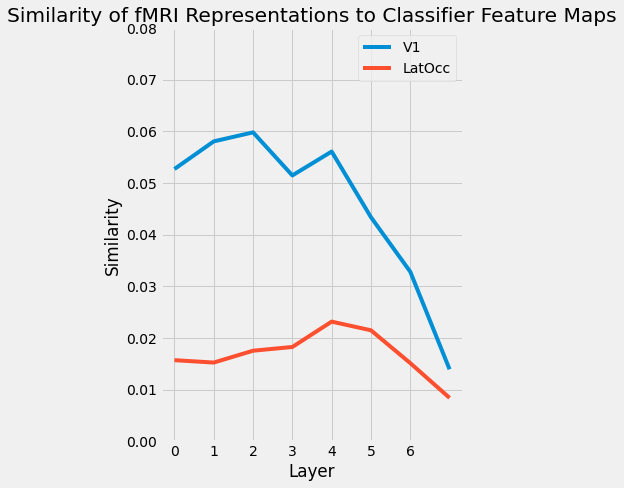

In [31]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(sim_v1, label='V1')
ax.plot(sim_latocc, label='LatOcc')
ax.set(title='Similarity of fMRI Representations to Classifier Feature Maps',
       xlabel='Layer', ylabel='Similarity', xticks=range(0, 7), ylim=(0, 0.08))
      #  xticks=[0, 1, 2, 3,], xticklabels=['A', 'B', 'C', 'D'])
ax.legend()
plt.tight_layout()
plt.show()

In [32]:
fmri_v1 = fmri_responses[:, roi == roi_map['V1']]
fmri_latocc = fmri_responses[:, roi == roi_map['LatOcc']]

sim_v1 = [compute_similarity(fmri_v1, activations_simclr[key])
          for key in activations_simclr.keys()]
sim_latocc = [compute_similarity(fmri_latocc, activations_simclr[key])
              for key in activations_simclr.keys()]

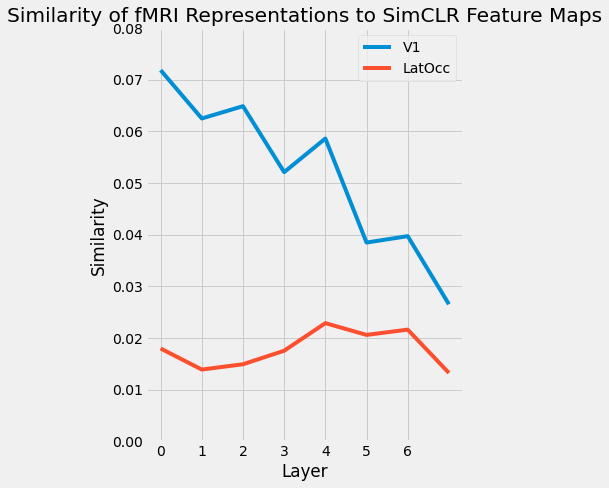

In [33]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(sim_v1, label='V1')
ax.plot(sim_latocc, label='LatOcc')
ax.set(title='Similarity of fMRI Representations to SimCLR Feature Maps',
       xlabel='Layer', ylabel='Similarity', xticks=range(0, 7), ylim=(0, 0.08))
      #  xticks=[0, 1, 2, 3,], xticklabels=['A', 'B', 'C', 'D'])
ax.legend()
plt.tight_layout()
plt.show()